In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import xobjects as xo
import matplotlib.pyplot as plt

In [3]:
line = xt.Line.from_json('../PIMMStutorials_CNAOlattice/cnao_lattice_00_optics.json')
line.build_tracker()

Loading line from dict:   0%|          | 0/429 [00:00<?, ?it/s]

Done loading line from dict.           


### Define reference particle

In [4]:
line.particle_ref = xt.Particles(q0=1, mass0=xt.PROTON_MASS_EV,
                                 kinetic_energy0=60e6)

### Match

In [5]:
# Build a single match with all constraints (can be reused to retune the machine)
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['s0', 's1'], step=1e-3, tag = 'sext'),
        xt.VaryList(['kf', 'kd','kr'], limits=(0, 1),  step=1e-3, tag='quad')
    ],
    targets=[
        xt.TargetSet(dqx=-3, dqy=-1, tol=1e-3, tag="chrom"),
        xt.Target(dx = 0, at='symp', tol=1e-6),
        xt.TargetSet(qx=1.666, qy=1.74, tol=1e-6),
    ]
)
# Perform twenty optimization steps
opt.step(20)

                                             
Optimize - start penalty: 3.415         
Matching: model call n. 22               
Optimize - end penalty:  3.10671e-06


### Twiss

In [6]:
tw = line.twiss(method='4d')

### Build a matched beam distribution

In [7]:
# Define number of turns and number of particles for the simulation
num_turns = 4000
num_particles = 100

# Generate Gaussian distribution in normalized phase space
x_norm = np.random.normal(size=num_particles)
px_norm = np.random.normal(size=num_particles)
y_norm = np.random.normal(size=num_particles)
py_norm = np.random.normal(size=num_particles)

# Generate Gaussian momentum distribution (mean 0.0, std spread 1e-4)
delta = np.random.normal(scale=1e-4, size=num_particles)

# Particles arrival time spread over one turn
zeta = np.random.uniform(low=-0.5, high=0.5, size=num_particles) * line.get_length()

# Assemble Particles object
particles = line.build_particles(
    x_norm=x_norm, px_norm=px_norm, 
    y_norm=y_norm, py_norm=py_norm,
    delta=delta,
    zeta=zeta,
    method='4d',
    nemitt_x=0.52e-6, nemitt_y=1e-8,
)

# save initial state
p0 = particles.copy()

In [8]:
# Set realistic septum aperture
line['septum_aperture'].max_x = 0.035

# Switch to multithreaded context to gain speed
ctx = xo.ContextCpu(omp_num_threads='auto')

# Enable time-dependent vars update for tracking
line.enable_time_dependent_vars = True

### Introduce RF Cavity

In [9]:
f_rev = 1 / tw.T_rev0
rf_cavity = xt.Cavity(voltage=1e3, frequency=f_rev)

In [10]:
# Install the custom RF cavity (thin element) in the center of the actual RF cavity.
# This way the actual RF cavity of the CNAO lattice (which is considered a drift) is sliced.
line.discard_tracker()
line.insert('rf_cavity', rf_cavity, at=49.2291)
line.build_tracker(_context=ctx)

Slicing line:   0%|          | 0/429 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


### Reset the model

In [11]:
# Reset simulation time
line.vars['t_turn_s'] = 0

### Track!

In [12]:
line.track(p0, num_turns=num_turns, with_progress=True, turn_by_turn_monitor=True)

Tracking:   0%|          | 0/4000 [00:00<?, ?it/s]

In [13]:
# Record particle coordinates turn by turn
rec = line.record_last_track
# Get turn by turn normalized coordinates 
nc = tw.get_normalized_coordinates(rec)

/home/aefstrat/miniforge3/lib/python3.12/site-packages/xtrack/twiss.py:3238: RuntimeWarning: invalid value encountered in divide
  pzeta = ctx2np(particles.ptau)[mask_at_ele]/ctx2np(particles.beta0)[mask_at_ele],


### Plot particles after tracking

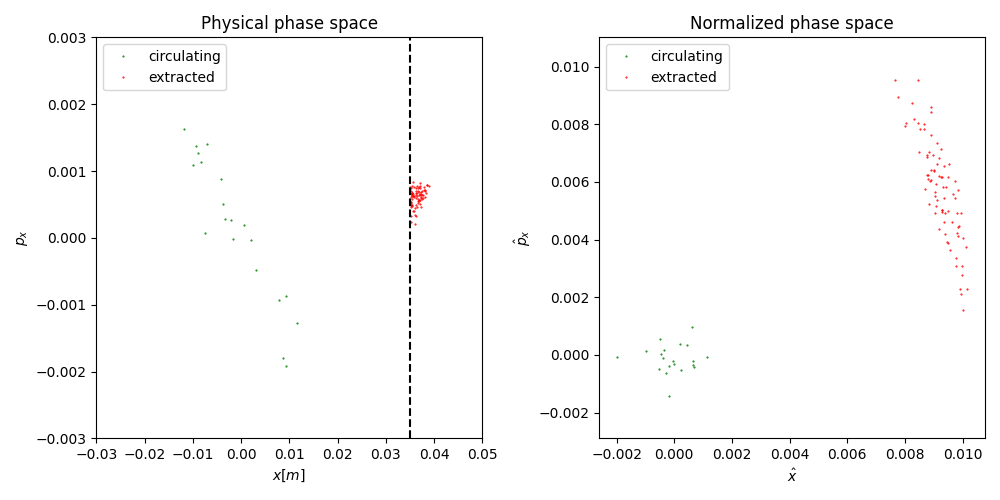

In [14]:
mask_alive = p0.state>0
mask_lost = ~mask_alive

# Get particles normalized coordinates
p_nc = tw.get_normalized_coordinates(p0)

plt.figure(figsize=(10, 5))
ax_g = plt.subplot(1, 2, 1, title='Physical phase space')
ax_n = plt.subplot(1, 2, 2, title='Normalized phase space')

ax_g.plot(p0.x[mask_alive], p0.px[mask_alive],
         '.', markersize=1, color='green', label='circulating')
ax_g.plot(p0.x[mask_lost], p0.px[mask_lost],
         '.', markersize=1, color='red', label='extracted')
ax_g.set_xlim(-0.03, 0.05); ax_g.set_ylim(-3e-3, 3e-3)
ax_g.axvline(x=line['septum_aperture'].max_x, color='k', ls='--')
ax_g.set_xlabel(r'${x} [m]$')
ax_g.set_ylabel(r'${p}_x$')
ax_g.legend()

ax_n.plot(p_nc.x_norm[mask_alive], p_nc.px_norm[mask_alive],
         '.', markersize=1, color='green', label='circulating')
ax_n.plot(p_nc.x_norm[mask_lost], p_nc.px_norm[mask_lost],
         '.', markersize=1, color='red', label='extracted')
ax_n.set_aspect('equal', adjustable='datalim')
ax_n.set_xlabel(r'$\hat{x}$')
ax_n.set_ylabel(r'$\hat{p}_x$')
ax_n.legend()

plt.tight_layout()

plt.show()

## Sort particles

I create a copy of the ``p0`` particles object after tracking and I sort it according to the ``particle_id``, interleaving the lost particles.

In [15]:
p_sorted = p0.copy()
p_sorted.sort(interleave_lost_particles=True) # <-- Sorted by particle_id

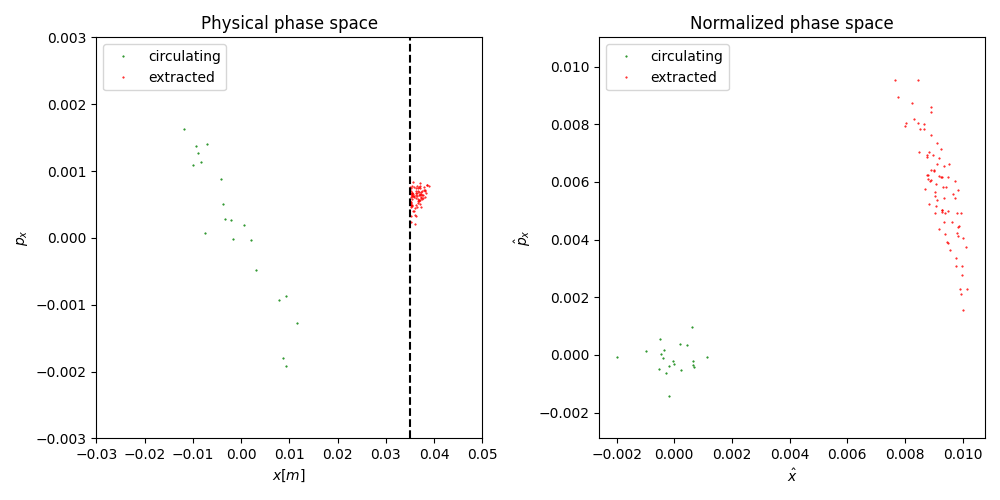

In [16]:
# Plot again the phase space, this time using the sorted particles object 
mask_al_sorted = p_sorted.state>0
mask_l_sorted = ~mask_al_sorted

# Get particles normalized coordinates
nc_sorted = tw.get_normalized_coordinates(p_sorted)

plt.figure(figsize=(10, 5))
ax_1 = plt.subplot(1, 2, 1, title='Physical phase space')
ax_2 = plt.subplot(1, 2, 2, title='Normalized phase space')

ax_1.plot(p_sorted.x[mask_al_sorted], p_sorted.px[mask_al_sorted],
         '.', markersize=1, color='green', label='circulating')
ax_1.plot(p_sorted.x[mask_l_sorted], p_sorted.px[mask_l_sorted],
         '.', markersize=1, color='red', label='extracted')
ax_1.set_xlim(-0.03, 0.05); ax_1.set_ylim(-3e-3, 3e-3)
ax_1.axvline(x=line['septum_aperture'].max_x, color='k', ls='--')
ax_1.set_xlabel(r'${x} [m]$')
ax_1.set_ylabel(r'${p}_x$')
ax_1.legend()

ax_2.plot(nc_sorted.x_norm[mask_al_sorted], nc_sorted.px_norm[mask_al_sorted],
         '.', markersize=1, color='green', label='circulating')
ax_2.plot(nc_sorted.x_norm[mask_l_sorted], nc_sorted.px_norm[mask_l_sorted],
         '.', markersize=1, color='red', label='extracted')
ax_2.set_aspect('equal', adjustable='datalim')
ax_2.set_xlabel(r'$\hat{x}$')
ax_2.set_ylabel(r'$\hat{p}_x$')
ax_2.legend()

plt.tight_layout()

plt.show()

In [17]:
# Inspect the mask lists for the sorted and unsorted particles, respectively 
print(f"After sorting:\n\n{mask_al_sorted}\n\n\nBefore sorting:\n\n{mask_alive}")

After sorting:

[False False False False False False  True False False False False  True
 False False False  True False False False  True False False  True False
 False  True False False  True False False False False False False False
 False False  True False False False False False False False False False
 False  True False False False False False  True  True False False False
  True  True False False False False False False False False  True False
 False  True False False False False False False False False  True  True
  True False  True False False False  True False False False False False
 False False False False]


Before sorting:

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False Fa

In [18]:
# Inspect the sorting of the rec object (record turn by turn monitor)
print(f"{rec.particle_id[:,0]}\n\n{rec.state[:,-1]}")

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]

[0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]


We can see that the ``rec`` object is sorted according the ``particle_id`` attribute, interleaving the lost particles (``particles.state = 0``). So, it makes sense to use the sorted particles object, instead of the unsorted one.